In [1]:
# Importing libraries to work with
import re
import os
import nltk
import spacy
import torch
import random
import numpy as np
import scipy as sci
import polars as pl
import pandas as pd
import gensim as gns
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# For the sake of Preprocessing
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Word Embedding
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# Sklearn
from sklearn.decomposition import PCA

In [2]:
# Display the libraries' versions used in this notebook
version_list = {"NumPy Version:": np.__version__,
                "Polars Version:": pl.__version__,
                "MatPlotLib Version:": mpl.__version__,
                "Seaborn Version:": sns.__version__,
                "PyTorch Version:": torch.__version__,
                "NLTK Version:": nltk.__version__,
                "SpaCy Version:": spacy.__version__,
                "Gensim Version:": gns.__version__,
                "SciPy Version:": sci.__version__}

for (k, v) in version_list.items():
    print(k, v)

NumPy Version: 1.26.4
Polars Version: 1.12.0
MatPlotLib Version: 3.9.2
Seaborn Version: 0.13.2
PyTorch Version: 2.5.1+cpu
NLTK Version: 3.9.1
SpaCy Version: 3.8.2
Gensim Version: 4.3.3
SciPy Version: 1.13.1


In [3]:
# Defining path to install NLTK libraries in
NLTK_LIB_PATH = ".\\venv_nlp\\Lib\\nltk_data"

# Defining download function
def download_libs():
    # Download extra parts of the library to use
    try:
        nltk.data.find("tokenizers\\punkt.zip")                     # Punctuation
        print("Punctuation Data Exists.")
    except LookupError:
        nltk.download('punkt', download_dir = NLTK_LIB_PATH)

    try:
        nltk.data.find("corpora\\stopwords.zip")                    # Stopwords
        print("Stopwords Package Exists.")
    except LookupError:
        nltk.download('stopwords', download_dir = NLTK_LIB_PATH)

    try:
        nltk.data.find("corpora\\wordnet.zip")                      # Corpus
        print("Wordnet Package Exists.")
    except LookupError:
        nltk.download('wordnet', download_dir = NLTK_LIB_PATH)

try:
    os.mkdir(NLTK_LIB_PATH)

    print("Directory for NLTK Packages Created.. Installing (Hopefully)")
    download_libs()
except FileExistsError:
    print("Directory Exists.")
    download_libs()
except:
    print("Couldn't Make Directory.")
    exit()

Directory Exists.
Punctuation Data Exists.
Stopwords Package Exists.
Wordnet Package Exists.


# Data Loading
Importing our csv into our workspace.

In [4]:
# Loading dataframe
text_data = pl.read_csv("datasets/twitter_training.csv", has_header=False, new_columns = ["tweet_id", "entity", "sentiment", "tweet_content"])

In [5]:
# Viewing first 10 rows
text_data.head(10)

tweet_id,entity,sentiment,tweet_content
i64,str,str,str
2401,"""Borderlands""","""Positive""","""im getting on borderlands and …"
2401,"""Borderlands""","""Positive""","""I am coming to the borders and…"
2401,"""Borderlands""","""Positive""","""im getting on borderlands and …"
2401,"""Borderlands""","""Positive""","""im coming on borderlands and i…"
2401,"""Borderlands""","""Positive""","""im getting on borderlands 2 an…"
2401,"""Borderlands""","""Positive""","""im getting into borderlands an…"
2402,"""Borderlands""","""Positive""","""So I spent a few hours making …"
2402,"""Borderlands""","""Positive""","""So I spent a couple of hours d…"
2402,"""Borderlands""","""Positive""","""So I spent a few hours doing s…"


In [6]:
# Checking for nulls
text_data.describe()

statistic,tweet_id,entity,sentiment,tweet_content
str,f64,str,str,str
"""count""",74682.0,"""74682""","""74682""","""73996"""
"""null_count""",0.0,"""0""","""0""","""686"""
"""mean""",6432.586165,null,null,null
"""std""",3740.42787,null,null,null
"""min""",1.0,"""Amazon""","""Irrelevant""",""" """
"""25%""",3195.0,null,null,null
"""50%""",6422.0,null,null,null
"""75%""",9601.0,null,null,null
"""max""",13200.0,"""johnson&johnson""","""Positive""","""🧻 at Home Depot on Hanley... I…"


Considering our Null count within the tweet content column is practically $<1\%$ (to be exact $0.927\%$), we can safely drop those rows

In [7]:
# Dropping nulls
text_data = text_data.drop_nulls('tweet_content')
text_data = text_data.drop('tweet_id')

In [8]:
# Viewing the available rows and their information
text_data.describe()

statistic,entity,sentiment,tweet_content
str,str,str,str
"""count""","""73996""","""73996""","""73996"""
"""null_count""","""0""","""0""","""0"""
"""mean""",null,null,null
"""std""",null,null,null
"""min""","""Amazon""","""Irrelevant""",""" """
"""25%""",null,null,null
"""50%""",null,null,null
"""75%""",null,null,null
"""max""","""johnson&johnson""","""Positive""","""🧻 at Home Depot on Hanley... I…"


# Preprocessing
Preprocessing the text so it's somewhat cleaner than when obtianed, so that the model doesn't struggle (Instead, we will :D ).

In [9]:
# Create a stopword set
stopwords = set(nltk.corpus.stopwords.words('english'))
stopwords.add("im")

In [10]:
# Define a regex function to remove special characters, links, etc.
def regex_cleanse(text: str):
    # URLS
    text = re.sub(r'https\S+', '', text)

    # @<username>
    text = re.sub(r'@\w+', '', text)

    # #<word>
    text = re.sub(r'#\w+', '', text)

    # One character that doesn't belong to word or whitespace
    text = re.sub(r'[^\w\s]', '', text)

    # Attempt to remove linked pictures URLs
    text = re.sub(r'pic\w+', '', text)
    text = " ".join([word for word in text.split() if word not in stopwords])

    return text

In [11]:
# Tokenisation Function
def tokeniser(text):
    return word_tokenize(text)

In [12]:
# Loading language model
model = spacy.load('en_core_web_sm')

# Lemmatiser
def lemma(tokens):
    doc = model(tokens)
    return [token.lemma_ for token in doc]

In [13]:
# Removing emojis
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [14]:
# Define a text preprocessing function to apply to all rows
def preprocess_text(text: str) -> list[str]:
    text = regex_cleanse(text.lower())
    text = remove_emoji(text)
    text = lemma(text)
    #text = tokeniser(text)
    return text

In [15]:
# Creating a cleaned-preprocessed dataset
cleaned = text_data.with_columns(pl.col('tweet_content').map_elements(preprocess_text, return_dtype = list[str]))

In [16]:
# Viewing
cleaned.head()

entity,sentiment,tweet_content
str,str,list[str]
"""Borderlands""","""Positive""","[""get"", ""borderland"", ""murder""]"
"""Borderlands""","""Positive""","[""come"", ""border"", ""kill""]"
"""Borderlands""","""Positive""","[""get"", ""borderland"", ""kill""]"
"""Borderlands""","""Positive""","[""come"", ""borderland"", ""murder""]"
"""Borderlands""","""Positive""","[""get"", ""borderland"", … ""murder""]"


# Word Embedding
Word Embedding

In [58]:
# Creating a series of vectors from every sentence
model_ready_text = cleaned['tweet_content'].to_list()

model_ready_text[0]

['get', 'borderland', 'murder']

In [89]:
# Training a Continuous Bag of Words, Word Embedding
word2vec_cbow = Word2Vec(model_ready_text, vector_size = 100,  sg = 0, workers = 10, window = 16, epochs = 250)

In [90]:
# Viewing the vector for the word
word2vec_cbow.wv['nvidia']

array([ 4.1708    ,  2.5556412 , -2.7784147 , -0.32316104,  0.68076813,
       -0.6993625 ,  2.1082616 ,  0.59875506, -7.843453  , -5.0200825 ,
        0.63230693, -4.8317833 ,  1.7556518 ,  4.922678  , -2.6182528 ,
       -0.40221888,  1.9318507 , -5.672102  ,  2.7366457 ,  7.310253  ,
        3.1390064 ,  0.9712022 ,  3.93474   ,  7.0052023 , -0.0545602 ,
        2.5172265 ,  0.1559714 , -1.3534343 , -2.781472  , -5.079161  ,
        0.09238643,  2.6379752 , -3.797446  ,  5.356047  ,  2.8157248 ,
       -8.840283  ,  0.7711648 ,  2.4726272 , -0.19333589,  0.43281356,
        1.1702726 ,  1.6487303 , -3.895999  , -2.4087818 , -3.433463  ,
        1.5381551 ,  9.362811  , -3.0132117 , -5.122207  ,  0.55872405,
       -2.7374556 ,  1.2788041 ,  0.46195006,  2.718978  , -5.7839575 ,
        3.3545468 ,  8.814933  ,  0.6021142 , -4.5628424 , -2.477504  ,
       -4.9968066 , -2.0850794 ,  1.1836935 ,  3.753556  ,  5.0457916 ,
       -0.5768391 ,  7.2305717 , -0.4890281 , -2.6039374 , -2.75

In [91]:
# Training a Skip-gram Word Embedding
word2vec_skgrm = Word2Vec(model_ready_text, vector_size = 100, sg = 1, workers = 10, window = 16, epochs = 250)

In [92]:
word2vec_skgrm.wv['nvidia']

array([ 0.36067045, -0.02757801,  0.2637943 , -0.14044571,  0.18617763,
       -0.3872232 , -0.1672852 , -0.00646967, -0.31155512, -0.11834538,
       -0.25345495, -0.4889921 , -0.12653701, -0.15870528, -0.12814352,
       -0.27499855,  0.15369292, -0.14637119,  0.22252946, -0.3437335 ,
       -0.46725476, -0.27716365,  0.12446845,  0.18798922,  0.0077842 ,
       -0.36554214,  0.16256373,  0.05538539,  0.10231612, -0.6549197 ,
       -0.3052411 ,  0.3245241 , -0.70517105, -0.366098  ,  0.25235167,
       -0.17180607,  0.13409497, -0.15752092, -0.03828128, -0.7561184 ,
       -0.23452468, -0.43283162,  0.316687  ,  0.5369664 ,  0.51968396,
        0.40691963, -0.06329848,  0.18613558, -0.3726863 ,  0.01602807,
       -0.24047358, -0.28324184,  0.2925151 , -0.06258814, -0.2400235 ,
       -0.34742317, -0.226932  ,  0.5308617 ,  0.3659496 ,  0.25783062,
       -0.2060195 ,  0.2726472 ,  0.04867858,  0.11178032, -0.27144846,
        0.19736768,  0.53279835, -0.00855964, -0.03478643,  0.51

In [93]:
corpus = list(word2vec_cbow.wv.index_to_key)

len(corpus)

12157

In [94]:
sample_size = 35

random_word_sample = random.sample(corpus, sample_size)

print(random_word_sample)

['t2', 'easy', 'introduce', '4x', 'apk', 'speechless', 'gen', 'versus', 'chin', 'ful', 'coulda', 'mystic', 'packaging', 'lahm', 'hotline', 'joel', 'rubbish', 'pleased', 'ddddd', 'ability', 'love', 'exchange', 'track', 'caitlyn', 'revenant', 'redirect', 'sunt', 'daioh', 'hardware', 'canofworm', 'mechathun', 'crore', 'bestfriend', '50', 'momentarily']


In [95]:
# Making a set of similar words per word for each model
similar_cbows = {word: word2vec_cbow.wv.most_similar(word, topn = 5) for word in random_word_sample}
similar_skgrm = {word: word2vec_skgrm.wv.most_similar(word, topn = 5) for word in random_word_sample}

In [96]:
print(similar_cbows)

{'t2': [('regional', 0.7819893956184387), ('pasa', 0.48751360177993774), ('ellesmere', 0.4631443917751312), ('7001', 0.44726207852363586), ('sorta', 0.4386419355869293)], 'easy': [('social', 0.35527071356773376), ('sbmm', 0.3409755825996399), ('organic', 0.3260591924190521), ('emi', 0.31725916266441345), ('rbl', 0.3138221800327301)], 'introduce': [('lean', 0.3996814489364624), ('discrete', 0.3447134792804718), ('bestseller', 0.3425811529159546), ('market', 0.3385283350944519), ('dynasty', 0.33483994007110596)], '4x': [('timeless', 0.994050145149231), ('nozdormu', 0.9885267019271851), ('beautifully', 0.3779163658618927), ('resurrect', 0.36653876304626465), ('ttk', 0.3569478392601013)], 'apk': [('joe', 0.40309974551200867), ('thevergecom20201017215', 0.38364189863204956), ('apps', 0.3836152255535126), ('warzonemod', 0.38346970081329346), ('scarborough', 0.37348684668540955)], 'speechless': [('nibble', 0.6028828620910645), ('doose', 0.36039483547210693), ('pour', 0.3589402437210083), ('26

In [97]:
print(similar_skgrm)

{'t2': [('regional', 0.7074952125549316), ('qualification', 0.6130450367927551), ('traumatic', 0.5065072774887085), ('tu2', 0.4919734001159668), ('allison', 0.48176512122154236)], 'easy': [('mahome', 0.5209107995033264), ('findomme', 0.47492820024490356), ('finsub', 0.46765103936195374), ('ebonydom', 0.4595891237258911), ('2k5', 0.45640650391578674)], 'introduce': [('graduate', 0.4993053674697876), ('templar', 0.4901749789714813), ('precovid', 0.4826473891735077), ('spirit', 0.45967328548431396), ('armello', 0.44556528329849243)], '4x': [('timeless', 0.9961769580841064), ('nozdormu', 0.9952422976493835), ('unfortunately', 0.5142267346382141), ('sadly', 0.4835242033004761), ('unsuccessful', 0.4793263375759125)], 'apk': [('apps', 0.5343271493911743), ('www', 0.532996654510498), ('pmoindia', 0.49767598509788513), ('download', 0.47311827540397644), ('gamesradar', 0.47128674387931824)], 'speechless': [('nibble', 0.7284930348396301), ('61', 0.5616869330406189), ('pour', 0.5089097619056702), 

In [98]:
def plot_embeddings(model, words):
    word_vectors = [model.wv[word] for word in words]
    pca = PCA(n_components=2)
    result = pca.fit_transform(word_vectors)

    plt.figure(figsize=(8, 6))
    for i, word in enumerate(words):
        plt.scatter(result[i, 0], result[i, 1])
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
    plt.show()

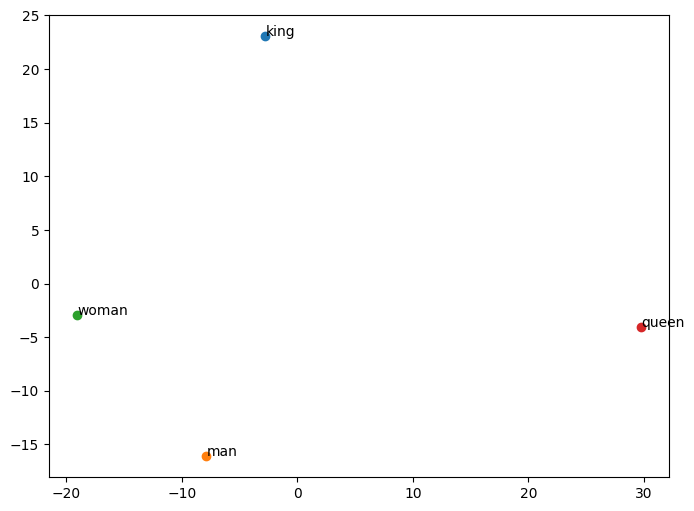

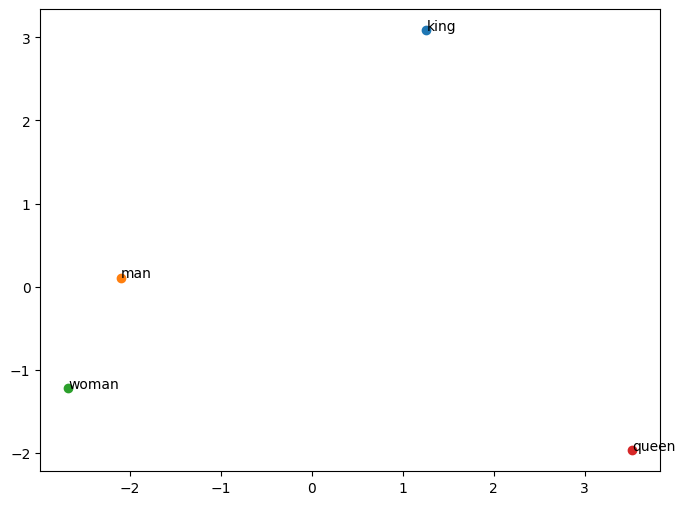

In [99]:
words = ['king', 'man', 'woman', 'queen']

plot_embeddings(word2vec_cbow, words)
plot_embeddings(word2vec_skgrm, words)

In [100]:
print(word2vec_skgrm.wv.most_similar(positive = ['king', 'woman'], topn = 5))

[('arias', 0.5711310505867004), ('taa', 0.5083791017532349), ('soprano', 0.5061912536621094), ('classical', 0.4939297139644623), ('cassandra', 0.48540163040161133)]
